In [1]:
# importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [2]:
# User input for Stock name , start and end date and also timeframe

import datetime

def get_user_input():
    stock_name1 = input("Enter the first stock name (e.g., AAPL, TSLA, GOOGL): ").strip()
    stock_name2 = input("Enter the second stock name (e.g., AAPL, TSLA, GOOGL): ").strip()
    while True:
        start_date = input("Enter the start date (YYYY-MM-DD): ").strip()
        try:
            start_date = datetime.datetime.strptime(start_date, "%Y-%m-%d")
            break
        except ValueError:
            print("Invalid date format. Please enter the date in YYYY-MM-DD format.")

    while True:
        end_date = input("Enter the end date (YYYY-MM-DD): ").strip()
        try:
            end_date = datetime.datetime.strptime(end_date, "%Y-%m-%d")
            if end_date > start_date:
                break
            else:
                print("End date must be after the start date.")
        except ValueError:
            print("Invalid date format. Please enter the date in YYYY-MM-DD format.")


    timeframes = ["daily", "weekly", "monthly"]
    print(f"Available timeframes: {', '.join(timeframes)}")
    while True:
        timeframe = input("Enter the timeframe (daily/weekly/monthly): ").strip().lower()
        if timeframe in timeframes:
            break
        else:
            print("Invalid timeframe. Please choose from daily, weekly, or monthly.")

    return stock_name1, stock_name2, start_date.strftime("%Y-%m-%d"), end_date.strftime("%Y-%m-%d"), timeframe

In [3]:
stock_name1, stock_name2, start_date, end_date, timeframe = get_user_input()

Enter the first stock name (e.g., AAPL, TSLA, GOOGL): AAPL
Enter the second stock name (e.g., AAPL, TSLA, GOOGL): GOOGL
Enter the start date (YYYY-MM-DD): 2012-01-01
Enter the end date (YYYY-MM-DD): 2025-01-01
Available timeframes: daily, weekly, monthly
Enter the timeframe (daily/weekly/monthly): daily


In [4]:
#import data from yfinance library which user asked for

def download_historical_data(symbol, start_date, end_date, timeframe):
    timeframe_map = {
        "daily": "1d",
        "weekly": "1wk",
        "monthly": "1mo"
    }

    yf_interval = timeframe_map.get(timeframe)

    data = yf.download(tickers=symbol, start=start_date, end=end_date, interval=yf_interval)
    return data

In [5]:
#data for first stock
data1 = download_historical_data(stock_name1, start_date, end_date, timeframe)
data1.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2012-01-03,12.345173,12.383299,12.278228,12.290237,302220800
2012-01-04,12.411516,12.448742,12.286633,12.308247,260022000
2012-01-05,12.549309,12.564919,12.388400,12.456847,271269600
2012-01-06,12.680499,12.691006,12.585035,12.601546,318292800
2012-01-09,12.660386,12.841107,12.648978,12.773563,394024400


In [6]:
#data for second stock
data2 = download_historical_data(stock_name2, start_date, end_date, timeframe)
data2.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,GOOGL,GOOGL,GOOGL,GOOGL,GOOGL
Date,,,,,
2012-01-03,16.537840,16.605939,16.213751,16.227916,146912940
2012-01-04,16.609169,16.658131,16.418790,16.528393,114445440
2012-01-05,16.378777,16.502051,16.309684,16.456321,131184684
2012-01-06,16.155342,16.403381,16.149625,16.382255,107608284
2012-01-09,15.470376,16.080283,15.439806,16.067857,232671096


In [7]:
data1pred = data1['Close']
data2pred = data2['Close']

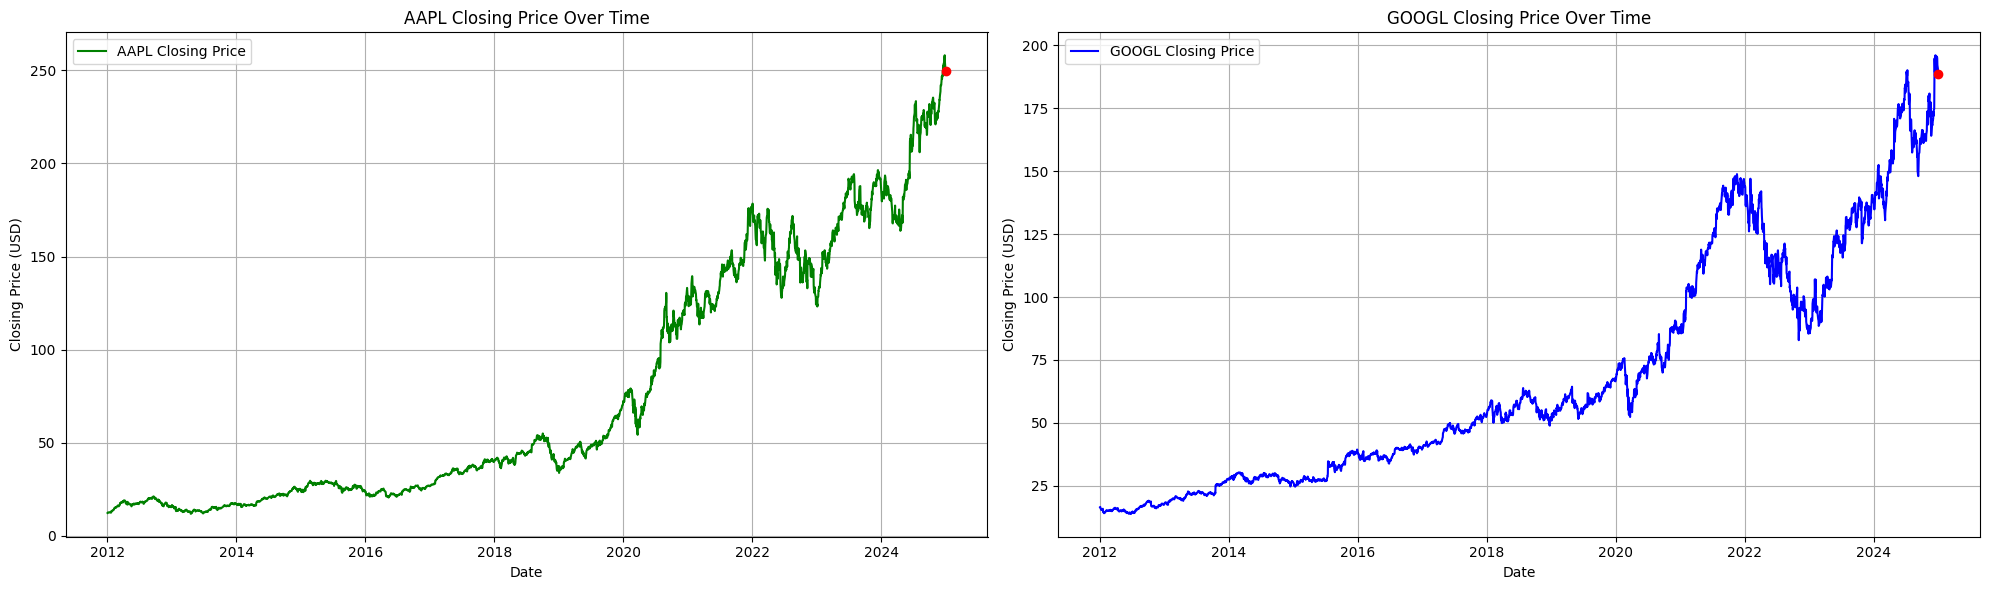

Last closing price for AAPL: Ticker
AAPL    249.53418
Name: 2024-12-31 00:00:00, dtype: float64
Last closing price for GOOGL: Ticker
GOOGL    188.68486
Name: 2024-12-31 00:00:00, dtype: float64


In [8]:
# plot all closing prices


fig, axes = plt.subplots(1, 2, figsize=(20, 6))
# Plot for the first stock
axes[0].plot(data1.index, data1['Close'], label=f'{stock_name1} Closing Price', color='green')
axes[0].plot(data1.index[-1], data1['Close'].iloc[-1], 'ro')  # Last value as a red dot
axes[0].set_title(f'{stock_name1} Closing Price Over Time')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Closing Price (USD)')
axes[0].legend()
axes[0].grid()

# Plot for the second stock
axes[1].plot(data2.index, data2['Close'], label=f'{stock_name2} Closing Price', color='blue')
axes[1].plot(data2.index[-1], data2['Close'].iloc[-1], 'ro')  # Last value as a red dot
axes[1].set_title(f'{stock_name2} Closing Price Over Time')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Closing Price (USD)')
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()
# Print the last values
print(f"Last closing price for {stock_name1}: {data1['Close'].iloc[-1]}")
print(f"Last closing price for {stock_name2}: {data2['Close'].iloc[-1]}")

In [9]:
# calculating a technical indicator MACD

def calculate_macd(data, short_window=12, long_window=26, signal_window=9):
    data['EMA_Short'] = data['Close'].ewm(span=short_window, adjust=False).mean()
    data['EMA_Long'] = data['Close'].ewm(span=long_window, adjust=False).mean()

    data['MACD'] = data['EMA_Short'] - data['EMA_Long']

    data['Signal_Line'] = data['MACD'].ewm(span=signal_window, adjust=False).mean()
    return data

In [10]:
# calculating another tachnical indicator RSI

def calculate_rsi(data, period=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    data['RSI'] = 100 - (100 / (1 + rs))
    return data


In [11]:
# Plotting MACD

def plot_macd(data1, data2, symbol1, symbol2):
    fig, axes = plt.subplots(1, 2, figsize=(20, 6))

    # Plot MACD for the first stock
    axes[0].plot(data1.index, data1['MACD'], label='MACD', color='blue')
    axes[0].plot(data1.index, data1['Signal_Line'], label='Signal Line', color='red')
    axes[0].set_title(f'{symbol1} MACD')
    axes[0].set_xlabel('Date')
    axes[0].set_ylabel('Value')
    axes[0].legend()
    axes[0].grid()

    # Plot MACD for the second stock
    axes[1].plot(data2.index, data2['MACD'], label='MACD', color='blue')
    axes[1].plot(data2.index, data2['Signal_Line'], label='Signal Line', color='red')
    axes[1].set_title(f'{symbol2} MACD')
    axes[1].set_xlabel('Date')
    axes[1].set_ylabel('Value')
    axes[1].legend()
    axes[1].grid()

    plt.tight_layout()
    plt.show()


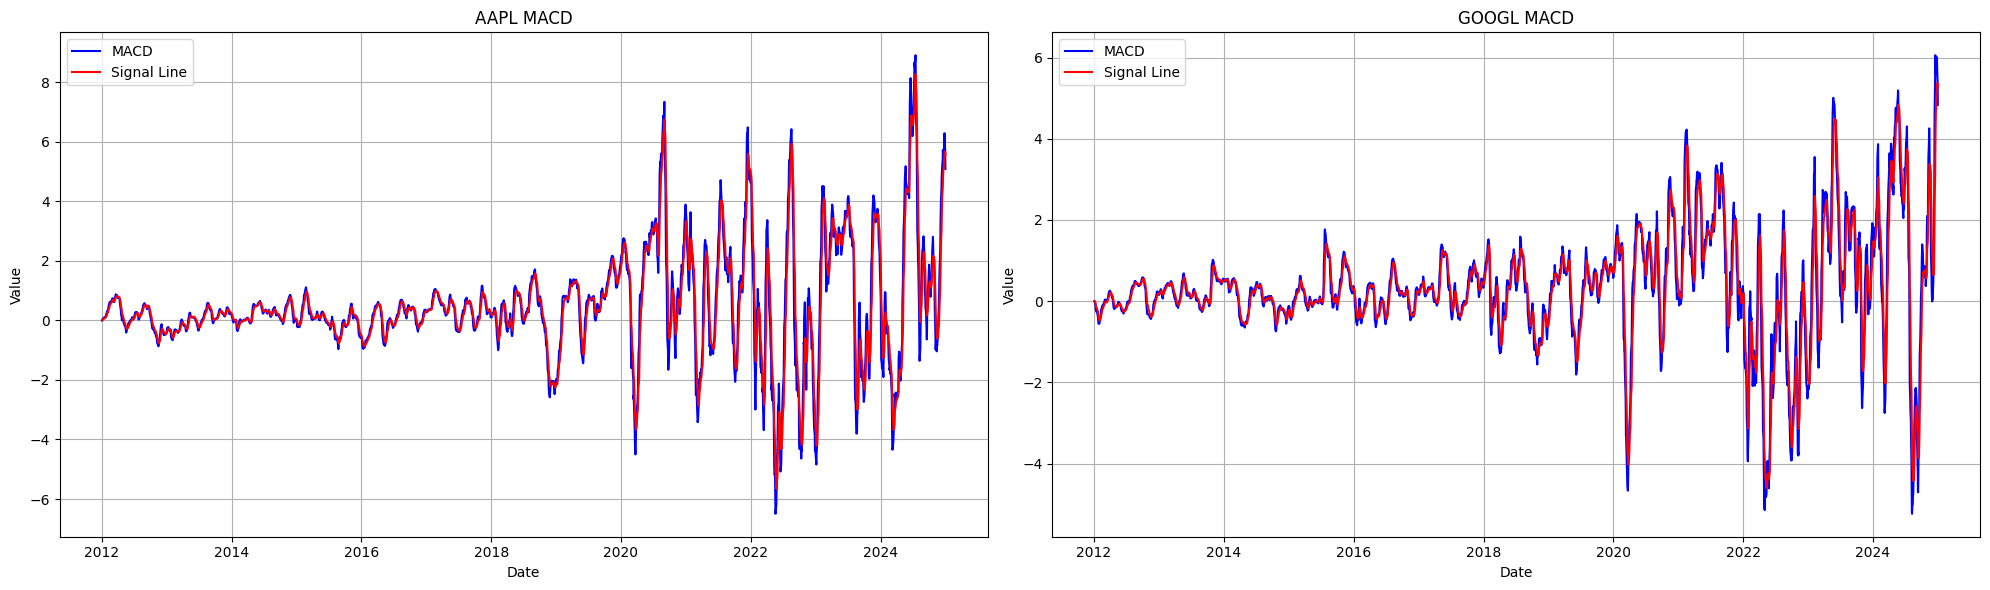

In [12]:
calculate_macd(data1).head()
calculate_macd(data2).head()
plot_macd(data1, data2,stock_name1, stock_name2)

In [13]:
# Plotting RSI

def plot_rsi(data1, data2, symbol1, symbol2):
    fig, axes = plt.subplots(1, 2, figsize=(20, 6))

    # Plot RSI for the first stock
    axes[0].plot(data1.index, data1['RSI'], label='RSI', color='purple')
    axes[0].axhline(70, color='red', linestyle='--', label='Overbought (70)')
    axes[0].axhline(30, color='green', linestyle='--', label='Oversold (30)')
    axes[0].set_title(f'{symbol1} RSI')
    axes[0].set_xlabel('Date')
    axes[0].set_ylabel('Value')
    axes[0].legend()
    axes[0].grid()

    # Plot RSI for the second stock
    axes[1].plot(data2.index, data2['RSI'], label='RSI', color='purple')
    axes[1].axhline(70, color='red', linestyle='--', label='Overbought (70)')
    axes[1].axhline(30, color='green', linestyle='--', label='Oversold (30)')
    axes[1].set_title(f'{symbol2} RSI')
    axes[1].set_xlabel('Date')
    axes[1].set_ylabel('Value')
    axes[1].legend()
    axes[1].grid()

    plt.tight_layout()
    plt.show()

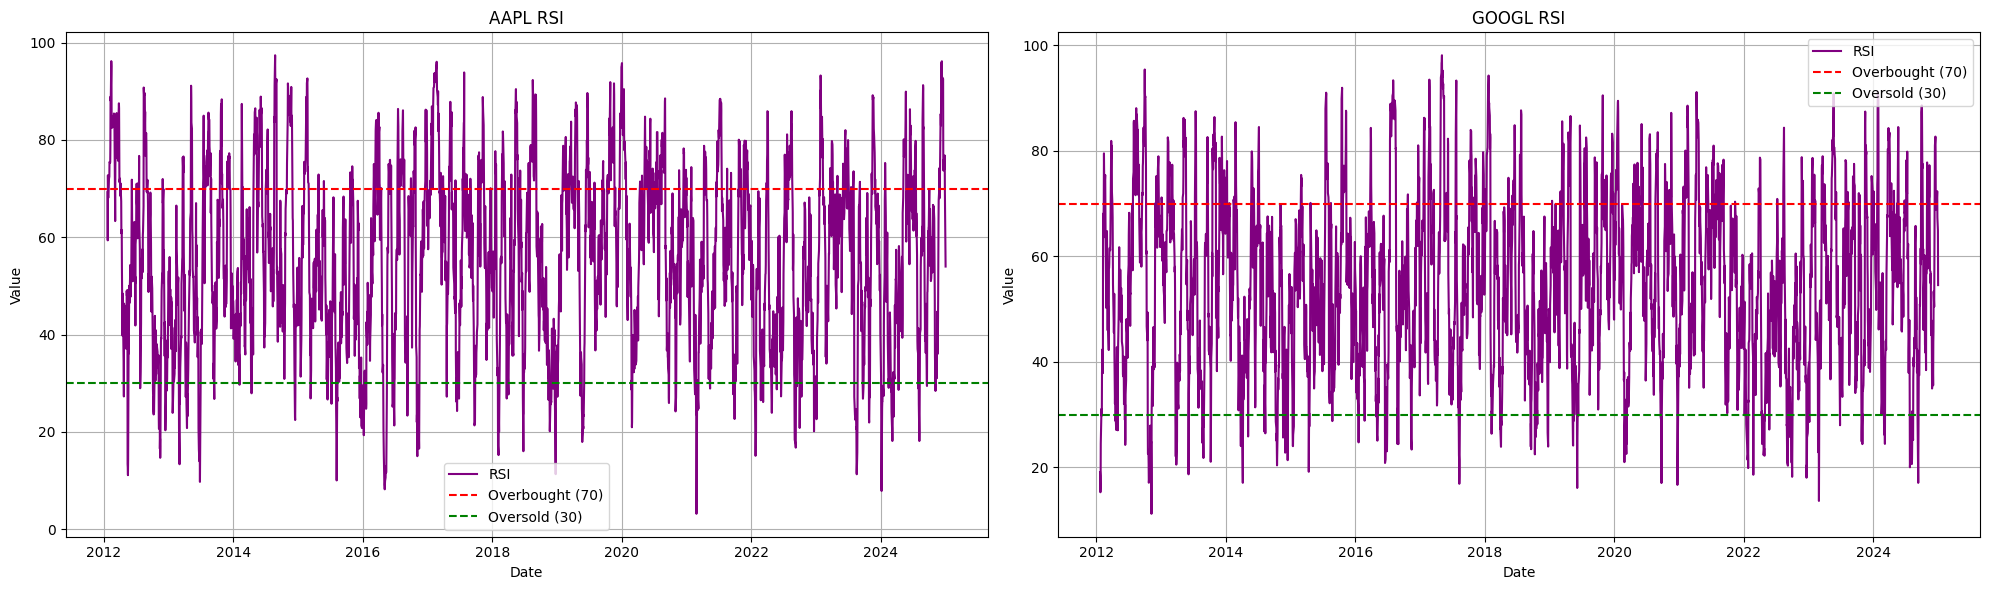

In [14]:
calculate_rsi(data1).head()
calculate_rsi(data2).head()
plot_rsi(data1, data2, stock_name1, stock_name2)

In [15]:
# Normalizing data

from sklearn.preprocessing import MinMaxScaler

def normalize_data(df, columns):
    scaler = MinMaxScaler(feature_range=(0, 1))
    df[columns] = scaler.fit_transform(df[columns])
    return df, scaler

columns_to_normalize1 = ['Close', 'Volume', 'EMA_Short', 'EMA_Long', 'MACD', 'Signal_Line']
columns_to_normalize2 = ['Close', 'Volume', 'EMA_Short', 'EMA_Long', 'MACD', 'Signal_Line']

df_normalized1, scaler1 = normalize_data(data1.copy(), columns_to_normalize1)
df_normalized2, scaler2 = normalize_data(data2.copy(), columns_to_normalize2)

In [16]:
df_normalized1.head()


Price,Close,High,Low,Open,Volume,EMA_Short,EMA_Long,MACD,Signal_Line,RSI
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,,,,,
Date,,,,,,,,,,
2012-01-03,0.001821,12.383299,12.278228,12.290237,0.188137,0.000000,0.000000,0.421800,0.406203,NaN
2012-01-04,0.002091,12.448742,12.286633,12.308247,0.159680,0.000043,0.000021,0.422144,0.406279,NaN
2012-01-05,0.002650,12.564919,12.388400,12.456847,0.167265,0.000167,0.000084,0.423123,0.406556,NaN
2012-01-06,0.003183,12.691006,12.585035,12.601546,0.198976,0.000357,0.000184,0.424555,0.407094,NaN
2012-01-09,0.003101,12.841107,12.648978,12.773563,0.250046,0.000505,0.000270,0.425541,0.407743,NaN


In [17]:
df_normalized2.head()

Price,Close,High,Low,Open,Volume,EMA_Short,EMA_Long,MACD,Signal_Line,RSI
Ticker,GOOGL,GOOGL,GOOGL,GOOGL,GOOGL,,,,,
Date,,,,,,,,,,
2012-01-03,0.014514,16.605939,16.213751,16.227916,0.282035,0.013606,0.012898,0.463554,0.461638,NaN
2012-01-04,0.014906,16.658131,16.418790,16.528393,0.215488,0.013669,0.012929,0.464058,0.461752,NaN
2012-01-05,0.013641,16.502051,16.309684,16.456321,0.249797,0.013520,0.012858,0.462819,0.461562,NaN
2012-01-06,0.012414,16.403381,16.149625,16.382255,0.201474,0.013199,0.012695,0.460278,0.460836,NaN
2012-01-09,0.008653,16.080283,15.439806,16.067857,0.457810,0.012329,0.012247,0.453484,0.458716,NaN


In [18]:
# Creating sequence with sliding window of past 60 days

def create_sequences(data, feature_columns, target_column, time_steps = 60):

    features = []
    targets = []
    for i in range(len(data) - time_steps):

        feature_window = data[feature_columns].iloc[i:i + time_steps].values

        target_value = data[target_column].iloc[i + time_steps]
        features.append(feature_window)
        targets.append(target_value)
    return np.array(features), np.array(targets)

In [19]:
# Ensure the data has enough rows to generate sequences # Adjust this value if necessary
time_steps = 10
if len(df_normalized1) > time_steps and len(df_normalized2) > time_steps:
        feature_columns1 = ['Close', 'Volume', 'EMA_Short', 'EMA_Long', 'MACD', 'Signal_Line']
        target_column1 = 'Close'
        feature_columns2 = ['Close', 'Volume', 'EMA_Short', 'EMA_Long', 'MACD', 'Signal_Line']
        target_column2 = 'Close'
        X1, y1 = create_sequences(df_normalized1, feature_columns1, target_column1, time_steps)
        X2, y2 = create_sequences(df_normalized2, feature_columns2, target_column2, time_steps)

else:
        print("Not enough data to create sequences. Please check the data length and time steps.")

In [20]:
# Designing LSTM model using depp learning framework using tensorflow

def create_lstm_model(input_shape, dropout_rate=0.2):
    model = Sequential()

    model.add(LSTM(64, activation='relu', return_sequences=True, input_shape=input_shape))
    model.add(Dropout(dropout_rate))

    model.add(LSTM(64, activation='relu', return_sequences=False))
    model.add(Dropout(dropout_rate))

    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [21]:
# Ensure X1 and y1 are not empty
if X1.size == 0 or y1.size == 0:
    print("X1 or y1 is empty. Please check the data preparation steps.")
else:
    # train-test split
    X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, shuffle=False)

    # Create and compile the LSTM model
    input_shape1 = (X_train1.shape[1], X_train1.shape[2])
    model1 = create_lstm_model(input_shape1)

    model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 64)         │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,265 (200.25 KB)

 Trainable params: 51,265 (200.25 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# Ensure X2 and y2 are not empty
if X2.size == 0 or y2.size == 0:
        print("X2 or y2 is empty. Please check the data preparation steps.")
else:
        # train-test split
        X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, shuffle=False)
        print(len(X_train2),len(X_test2),len(y_train2),len(y_test2))
        # Create and compile the LSTM model
        input_shape2 = (X_train2.shape[1], X_train2.shape[2])
        model2 = create_lstm_model(input_shape2)

        model2.summary()

2608 652 2608 652


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 10, 64)         │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,265 (200.25 KB)

 Trainable params: 51,265 (200.25 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# Training the model

history1 = model1.fit(
    X_train1, y_train1,
    epochs=20,
    batch_size=32,
    validation_data=(X_test1, y_test1),
    verbose=1
)

loss, mae = model1.evaluate(X_test1, y_test1, verbose=0)
print(f"Test Loss: {loss:.4f}, Test MAE: {mae:.4f}")

Epoch 1/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.0154 - mae: 0.0768 - val_loss: 0.0012 - val_mae: 0.0276
Epoch 2/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0011 - mae: 0.0200 - val_loss: 0.0010 - val_mae: 0.0270
Epoch 3/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 8.7528e-04 - mae: 0.0178 - val_loss: 6.3353e-04 - val_mae: 0.0205
Epoch 4/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 8.1005e-04 - mae: 0.0172 - val_loss: 0.0023 - val_mae: 0.0420
Epoch 5/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 6.7614e-04 - mae: 0.0155 - val_loss: 6.6528e-04 - val_mae: 0.0205
Epoch 6/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 6.7067e-04 - mae: 0.0151 - val_loss: 9.0143e-04 - val_mae: 0.0245
Epoch 7/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 5.7968e-04 - mae: 0.0140 - val_loss: 6.6593e-04 - val_mae: 0.0200
Epoch 8/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 6.4890e-04 - mae: 0.0148 - val_loss: 6.5969e-04 - val_mae: 0.0199
Epoch 9/20
82/82 ━━━

In [24]:
# Training the model

history2 = model2.fit(
    X_train2, y_train2,
    epochs=20,
    batch_size=32,
    validation_data=(X_test2, y_test2),
    verbose=1
)

loss, mae = model1.evaluate(X_test2, y_test2, verbose=0)
print(f"Test Loss: {loss:.4f}, Test MAE: {mae:.4f}")

Epoch 1/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0286 - mae: 0.1140 - val_loss: 0.0029 - val_mae: 0.0390
Epoch 2/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0017 - mae: 0.0267 - val_loss: 0.0015 - val_mae: 0.0300
Epoch 3/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0016 - mae: 0.0256 - val_loss: 0.0015 - val_mae: 0.0310
Epoch 4/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0016 - mae: 0.0263 - val_loss: 0.0016 - val_mae: 0.0298
Epoch 5/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0014 - mae: 0.0233 - val_loss: 0.0010 - val_mae: 0.0245
Epoch 6/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0012 - mae: 0.0227 - val_loss: 0.0010 - val_mae: 0.0257
Epoch 7/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0012 - mae: 0.0214 - val_loss: 0.0016 - val_mae: 0.0329
Epoch 8/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0010 - mae: 0.0196 - val_loss: 0.0032 - val_mae: 0.0488
Epoch 9/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.001

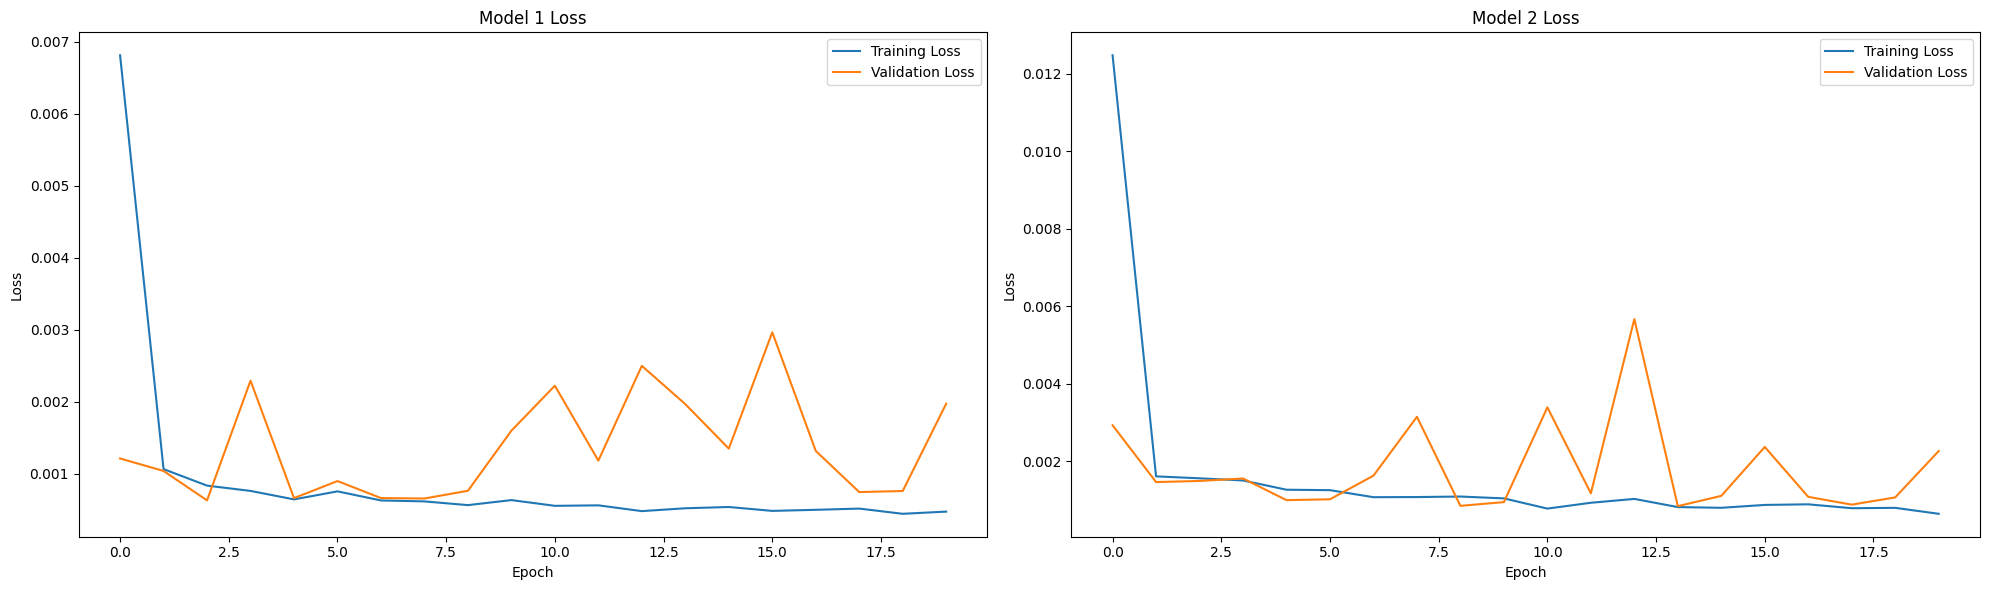

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Plot for history1
axes[0].plot(history1.history['loss'], label='Training Loss')
axes[0].plot(history1.history['val_loss'], label='Validation Loss')
axes[0].set_title('Model 1 Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Plot for history2
axes[1].plot(history2.history['loss'], label='Training Loss')
axes[1].plot(history2.history['val_loss'], label='Validation Loss')
axes[1].set_title('Model 2 Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.tight_layout()
plt.show()

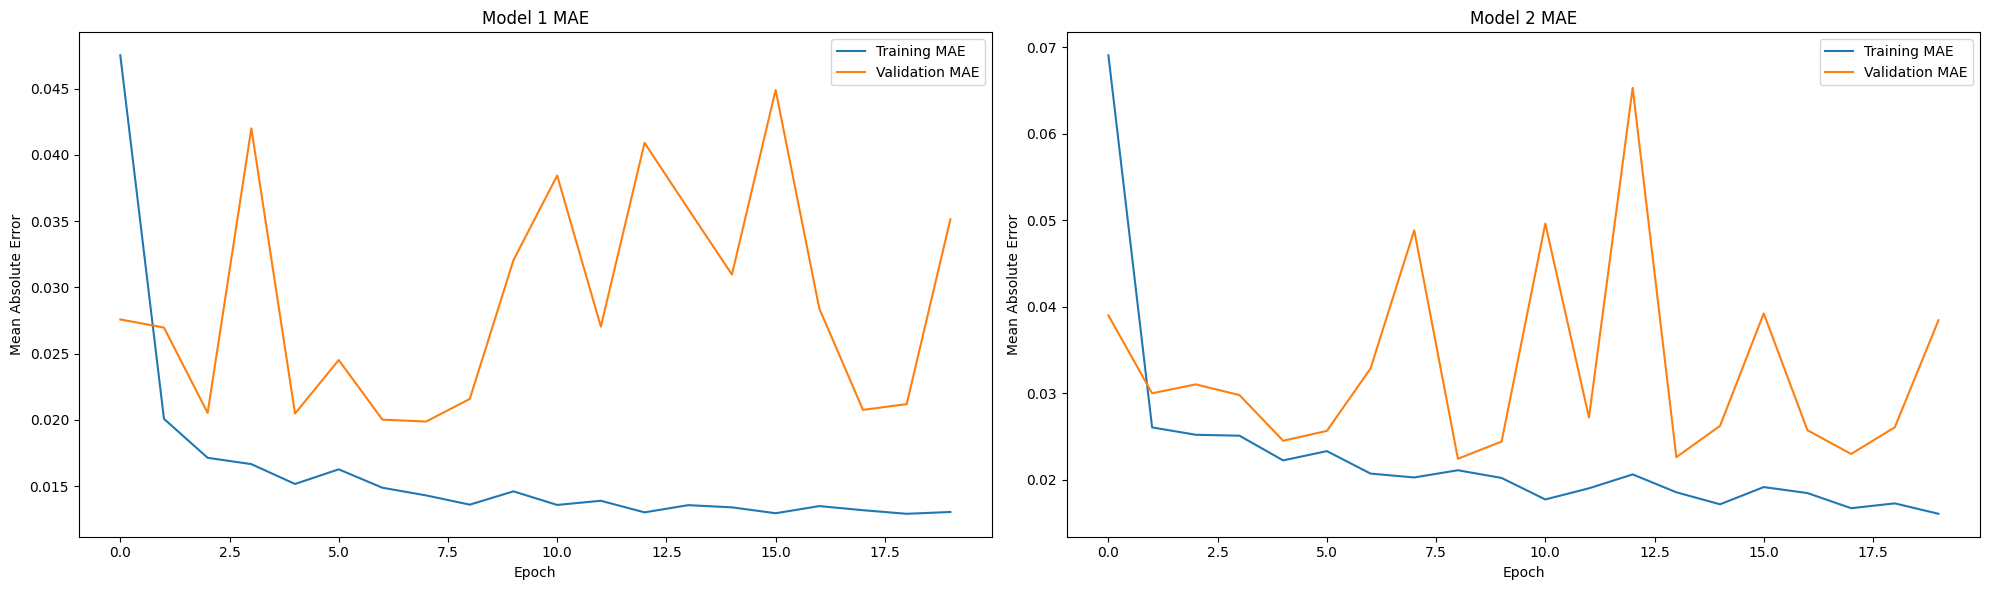

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Plot for history1
axes[0].plot(history1.history['mae'], label='Training MAE')
axes[0].plot(history1.history['val_mae'], label='Validation MAE')
axes[0].set_title('Model 1 MAE')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Mean Absolute Error')
axes[0].legend()

# Plot for history2
axes[1].plot(history2.history['mae'], label='Training MAE')
axes[1].plot(history2.history['val_mae'], label='Validation MAE')
axes[1].set_title('Model 2 MAE')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Mean Absolute Error')
axes[1].legend()

plt.tight_layout()
plt.show()

In [27]:
def predict_next_units(model, data, feature_columns, time_steps, n_predictions):
    predictions = []

    # Start with the last sequence of data
    last_sequence = data[feature_columns].iloc[-time_steps:].values

    for _ in range(n_predictions):
        # Reshape the last sequence to match the model's input shape
        input_data = np.expand_dims(last_sequence, axis=0)

        # Predict the next value (assuming the target is a single value like 'Close')
        predicted_value = model.predict(input_data, verbose=0)[0][0]

        # Append the prediction
        predictions.append(predicted_value)

        # Create a new sequence by adding the predicted value and removing the oldest
        new_row = np.copy(last_sequence[-1])  # Copy the last row to use as a base
        new_row[0] = predicted_value  # Update the target column (e.g., 'Close') with the prediction

        last_sequence = np.append(last_sequence[1:], [new_row], axis=0)

    return predictions


In [28]:
# Parameters
n_predictions1 = 15
time_steps1 = X_train1.shape[1]  # The sequence length used in training
feature_columns1 = ['Close', 'Volume', 'EMA_Short', 'EMA_Long', 'MACD', 'Signal_Line']  # Adjust to match your data

# Generate predictions
predicted_values1 = predict_next_units(model1, df_normalized1, feature_columns1, time_steps1, n_predictions1)

# Denormalize predictions (if normalization was applied)
scaler1 = MinMaxScaler(feature_range=(0, 1))  # Replace with your actual scaler
scaler1.fit(data1[['Close']])  # Fit scaler on the original 'Close' column

predicted_values_denormalized1 = scaler1.inverse_transform(
    np.array(predicted_values1).reshape(-1, 1)
)
# Display predictions
print("Next 15 predicted values (normalized):", predicted_values1)
print("Next 15 predicted values (denormalized):", predicted_values_denormalized1)

n_predictions2 = 15
time_steps2 = X_train2.shape[1]  # The sequence length used in training
feature_columns2 = ['Close', 'Volume', 'EMA_Short', 'EMA_Long', 'MACD', 'Signal_Line']

predicted_values2 = predict_next_units(model2, df_normalized2, feature_columns2, time_steps2, n_predictions2)

scaler2 = MinMaxScaler(feature_range=(0, 1))
scaler2.fit(data2[['Close']])

predicted_values_denormalized2 = scaler2.inverse_transform(
    np.array(predicted_values2).reshape(-1, 1)
)
print("Next 15 predicted values (normalized):", predicted_values2)
print("Next 15 predicted values (denormalized):", predicted_values_denormalized2)

Next 15 predicted values (normalized): [np.float32(0.88985246), np.float32(0.8866794), np.float32(0.88334894), np.float32(0.87953275), np.float32(0.8750445), np.float32(0.8707085), np.float32(0.8660035), np.float32(0.86127543), np.float32(0.85716796), np.float32(0.85376126), np.float32(0.8507035), np.float32(0.8493619), np.float32(0.8480959), np.float32(0.846927), np.float32(0.8458772)]
Next 15 predicted values (denormalized): [[230.98465]
 [230.20341]
 [229.38344]
 [228.44386]
 [227.33882]
 [226.27127]
 [225.11287]
 [223.94878]
 [222.9375 ]
 [222.09874]
 [221.34589]
 [221.01558]
 [220.70389]
 [220.41609]
 [220.15762]]
Next 15 predicted values (normalized): [np.float32(0.9070758), np.float32(0.9033472), np.float32(0.8999344), np.float32(0.89632237), np.float32(0.89231074), np.float32(0.8877849), np.float32(0.88309413), np.float32(0.8787048), np.float32(0.87509376), np.float32(0.8720923), np.float32(0.86972094), np.float32(0.86850905), np.float32(0.8673685), np.float32(0.8663119), np.fl

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


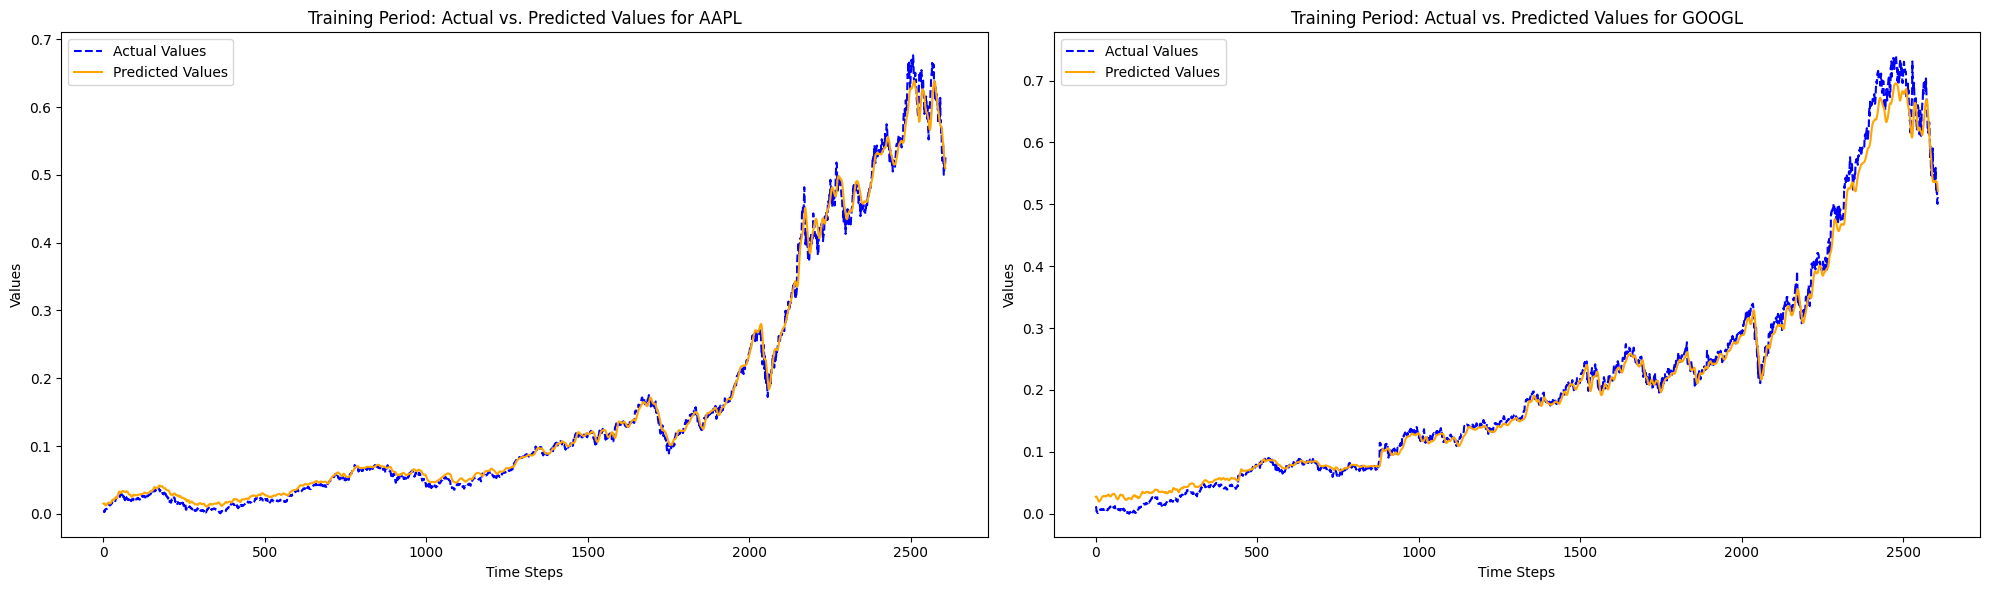

In [29]:
# Actual vs predicted graph for both stocks in a 1x2 matrix

fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Plot for the first stock
y_train_pred1 = model1.predict(X_train1)
axes[0].plot(range(len(y_train1)), y_train1, label="Actual Values", color="blue", linestyle="--")
axes[0].plot(range(len(y_train_pred1)), y_train_pred1, label="Predicted Values", color="orange")
axes[0].set_title(f"Training Period: Actual vs. Predicted Values for {stock_name1}")
axes[0].set_xlabel("Time Steps")
axes[0].set_ylabel("Values")
axes[0].legend()

# Plot for the second stock
y_train_pred2 = model2.predict(X_train2)
axes[1].plot(range(len(y_train2)), y_train2, label="Actual Values", color="blue", linestyle="--")
axes[1].plot(range(len(y_train_pred2)), y_train_pred2, label="Predicted Values", color="orange")
axes[1].set_title(f"Training Period: Actual vs. Predicted Values for {stock_name2}")
axes[1].set_xlabel("Time Steps")
axes[1].set_ylabel("Values")
axes[1].legend()

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


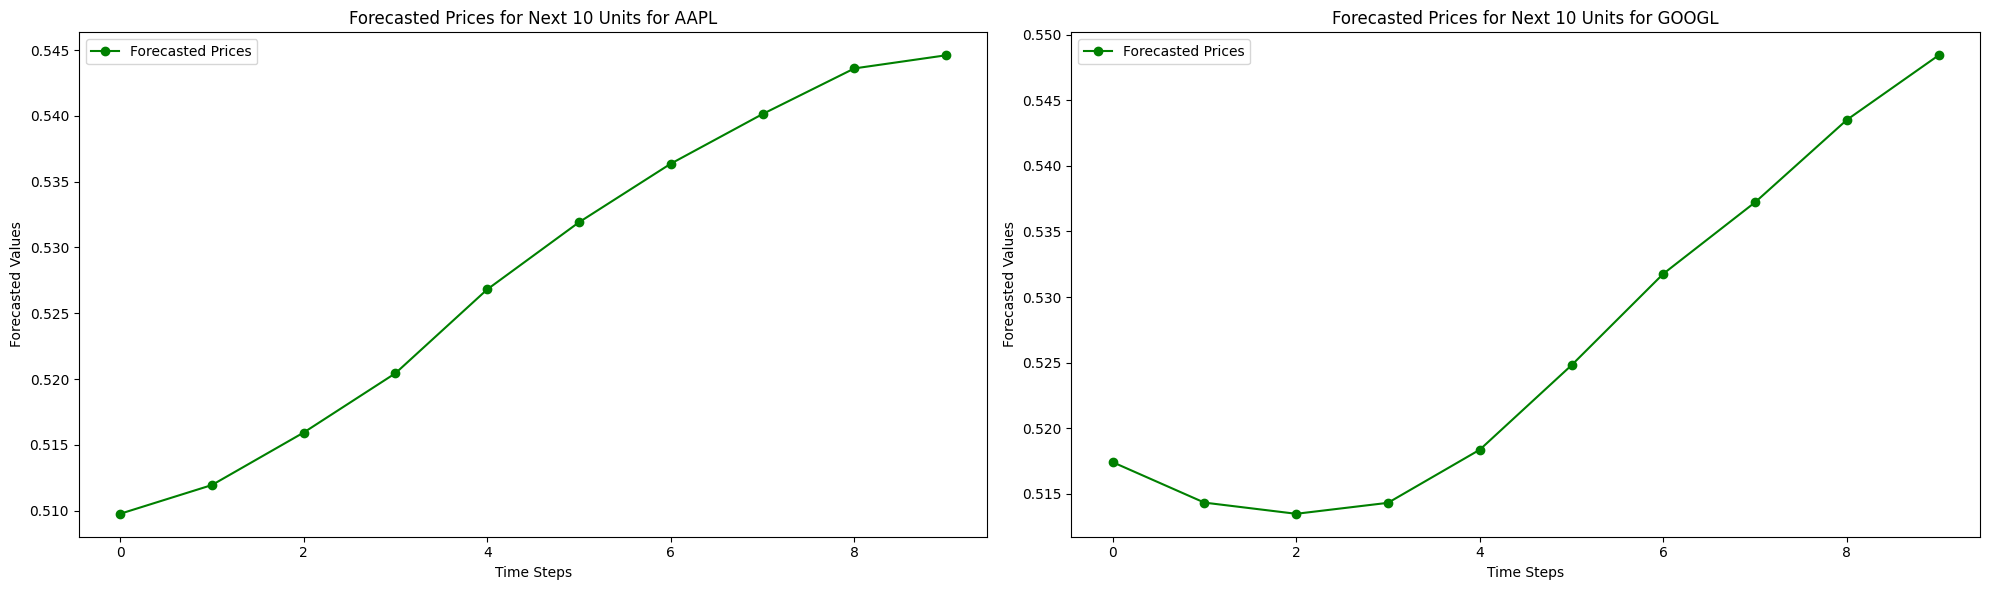

In [30]:
# forecasted graph
forecasted_prices1 = model1.predict(X_test1[:10]).flatten()  # Ensure the length matches y_test1
forecasted_prices2 = model2.predict(X_test2[:10]).flatten()  # Ensure the length matches y_test2

fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Plot for the first stock
axes[0].plot(range(10), forecasted_prices1, marker="o", color="green", label="Forecasted Prices")
axes[0].set_title(f"Forecasted Prices for Next 10 Units for {stock_name1}")
axes[0].set_xlabel("Time Steps")
axes[0].set_ylabel("Forecasted Values")
axes[0].legend()

# Plot for the second stock
axes[1].plot(range(10), forecasted_prices2, marker="o", color="green", label="Forecasted Prices")
axes[1].set_title(f"Forecasted Prices for Next 10 Units for {stock_name2}")
axes[1].set_xlabel("Time Steps")
axes[1].set_ylabel("Forecasted Values")
axes[1].legend()

plt.tight_layout()
plt.show()

In [31]:
# calculating R² for model1
ss_res1 = np.sum((y_train1 - y_train_pred1)**2)  # Residual sum of squares
ss_tot1 = np.sum((y_train1 - np.mean(y_train1))**2)  # Total sum of squares
r2_1 = 1 - (ss_res1 / ss_tot1)
print(f"R² Score for Training Period (Model 1): {r2_1:.4f}")

# calculating R² for model2
ss_res2 = np.sum((y_train2 - y_train_pred2)**2)  # Residual sum of squares
ss_tot2 = np.sum((y_train2 - np.mean(y_train2))**2)  # Total sum of squares
r2_2 = 1 - (ss_res2 / ss_tot2)
print(f"R² Score for Training Period (Model 2): {r2_2:.4f}")

R² Score for Training Period (Model 1): 0.9962
R² Score for Training Period (Model 2): 0.9919


In [32]:
import pandas as pd
import numpy as np

def calculate_metrics(data):
    # Calculate daily returns and drop NaN values
    daily_return = data.pct_change().dropna()

    # Calculate average return
    avg_return = daily_return.mean()

    # Calculate volatility (standard deviation of returns)
    volatility = daily_return.std()

    # Calculate Sharpe ratio (assuming risk-free rate is 0 for simplicity)
    sharpe_ratio = avg_return / volatility if volatility.any() != 0 else np.nan

    return avg_return, volatility, sharpe_ratio

# Assuming data1pred and data2pred are pandas DataFrames with a single stock price column
avg_return1, volatility1, sharpe_ratio1 = calculate_metrics(data1pred)
avg_return2, volatility2, sharpe_ratio2 = calculate_metrics(data2pred)

print(f"Metrics for {stock_name1}:")
print(f"Average Return: {avg_return1.values[0]:.4f}")
print(f"Volatility: {volatility1.values[0]:.4f}")
print(f"Sharpe Ratio: {sharpe_ratio1.values[0]:.4f}")

print(f"\nMetrics for {stock_name2}:")
print(f"Average Return: {avg_return2.values[0]:.4f}")
print(f"Volatility: {volatility2.values[0]:.4f}")
print(f"Sharpe Ratio: {sharpe_ratio2.values[0]:.4f}")

# Compare the stocks
best_stock = stock_name1 if sharpe_ratio1.values[0] > sharpe_ratio2.values[0] else stock_name2
print(f"\nThe better stock to buy for the long term based on the Sharpe Ratio is: {best_stock}")


Metrics for AAPL:
Average Return: 0.0011
Volatility: 0.0177
Sharpe Ratio: 0.0609

Metrics for GOOGL:
Average Return: 0.0009
Volatility: 0.0171
Sharpe Ratio: 0.0521

The better stock to buy for the long term based on the Sharpe Ratio is: AAPL


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


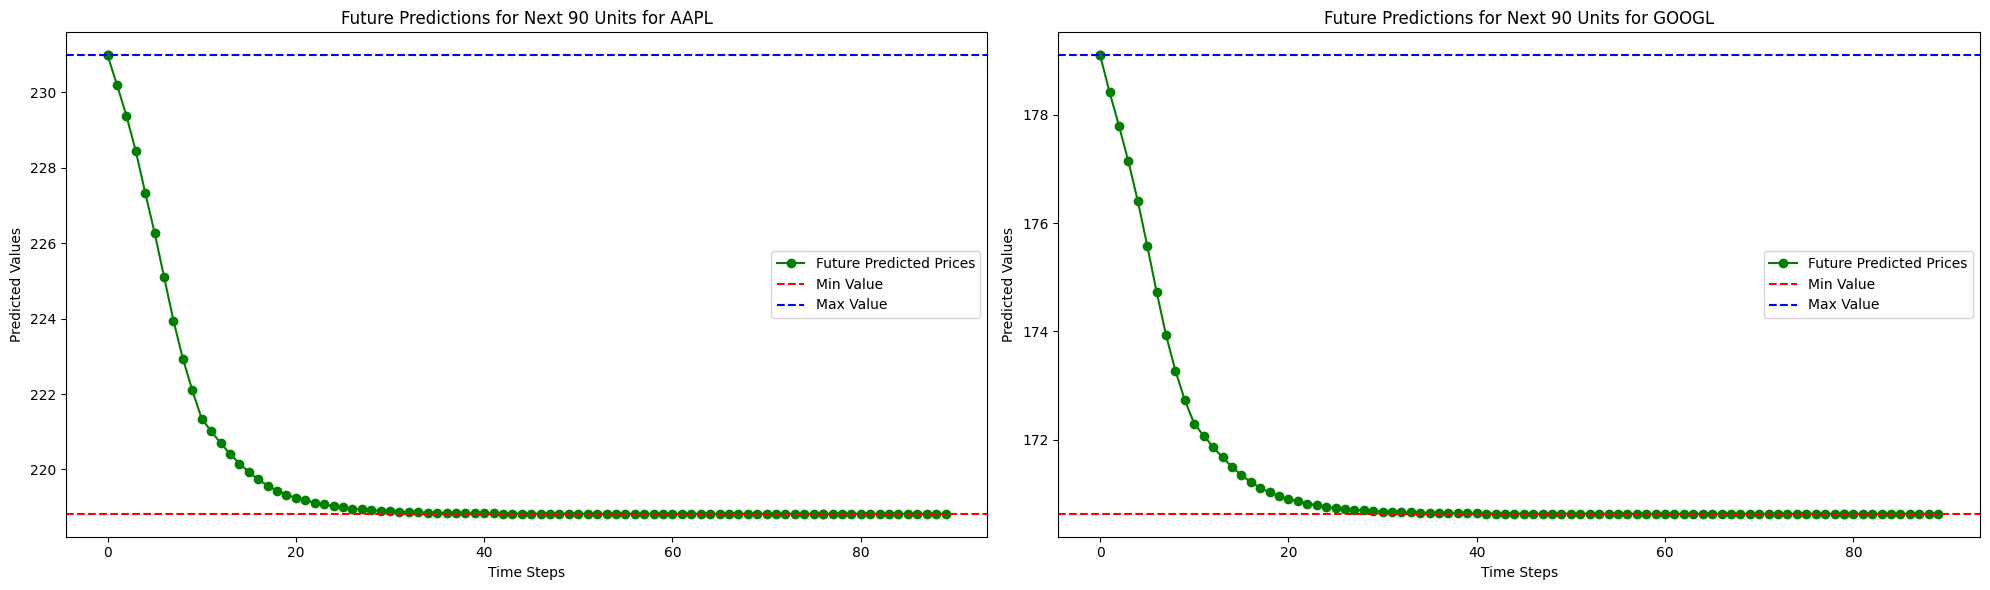

In [33]:
# Ensure the length of y_test1 and y_test2 matches the length of y_test_pred1 and y_test_pred2
y_test_pred1 = model1.predict(X_test1)
y_test_pred2 = model2.predict(X_test2)
assert len(y_test1) == len(y_test_pred1), "Length of y_test1 and y_test_pred1 must match"
assert len(y_test2) == len(y_test_pred2), "Length of y_test2 and y_test_pred2 must match"

# Parameters for future prediction
n_predictions1 = 90
time_steps1 = X_train1.shape[1]  # The sequence length used in training
feature_columns1 = ['Close', 'Volume', 'EMA_Short', 'EMA_Long', 'MACD', 'Signal_Line']  # Adjust to match your data

n_predictions2 = 90
time_steps2 = X_train2.shape[1]  # The sequence length used in training
feature_columns2 = ['Close', 'Volume', 'EMA_Short', 'EMA_Long', 'MACD', 'Signal_Line']

# Generate future predictions
predicted_values1 = predict_next_units(model1, df_normalized1, feature_columns1, time_steps1, n_predictions1)
predicted_values2 = predict_next_units(model2, df_normalized2, feature_columns2, time_steps2, n_predictions2)

# Denormalize predictions (if normalization was applied)
scaler1 = MinMaxScaler(feature_range=(0, 1))  # Replace with your actual scaler
scaler1.fit(data1[['Close']])  # Fit scaler on the original 'Close' column
predicted_values_denormalized1 = scaler1.inverse_transform(np.array(predicted_values1).reshape(-1, 1))

scaler2 = MinMaxScaler(feature_range=(0, 1))  # Replace with your actual scaler
scaler2.fit(data2[['Close']])  # Fit scaler on the original 'Close' column
predicted_values_denormalized2 = scaler2.inverse_transform(np.array(predicted_values2).reshape(-1, 1))

# Plotting the future predictions for both stocks
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Plot for the first stock
axes[0].plot(range(n_predictions1), predicted_values_denormalized1, marker="o", color="green", label="Future Predicted Prices")
axes[0].axhline(y=predicted_values_denormalized1.min(), color='red', linestyle='--', label='Min Value')
axes[0].axhline(y=predicted_values_denormalized1.max(), color='blue', linestyle='--', label='Max Value')
axes[0].scatter(predicted_values_denormalized1.argmin(), predicted_values_denormalized1.min(), color='red')  # Mark minima
axes[0].scatter(predicted_values_denormalized1.argmax(), predicted_values_denormalized1.max(), color='blue')  # Mark maxima
axes[0].set_title(f"Future Predictions for Next {n_predictions1} Units for {stock_name1}")
axes[0].set_xlabel("Time Steps")
axes[0].set_ylabel("Predicted Values")
axes[0].legend()

# Plot for the second stock
axes[1].plot(range(n_predictions2), predicted_values_denormalized2, marker="o", color="green", label="Future Predicted Prices")
axes[1].axhline(y=predicted_values_denormalized2.min(), color='red', linestyle='--', label='Min Value')
axes[1].axhline(y=predicted_values_denormalized2.max(), color='blue', linestyle='--', label='Max Value')
axes[1].scatter(predicted_values_denormalized2.argmin(), predicted_values_denormalized2.min(), color='red')  # Mark minima
axes[1].scatter(predicted_values_denormalized2.argmax(), predicted_values_denormalized2.max(), color='blue')  # Mark maxima
axes[1].set_title(f"Future Predictions for Next {n_predictions2} Units for {stock_name2}")
axes[1].set_xlabel("Time Steps")
axes[1].set_ylabel("Predicted Values")
axes[1].legend()

plt.tight_layout()
plt.show()

In [34]:
def calculate_loss_percentage(y_true, y_pred):
    # Calculate the absolute percentage error
    ape = np.abs((y_true - y_pred) / y_true) * 100
    # Calculate the mean absolute percentage error
    mape = np.mean(ape)
    return mape

# Calculate loss percentage for the first stock
loss_percentage1 = calculate_loss_percentage(y_test1, y_test_pred1)
print(f"Loss Percentage for {stock_name1} if bought for short term : {loss_percentage1:.2f}%")

# Calculate loss percentage for the second stock
loss_percentage2 = calculate_loss_percentage(y_test2, y_test_pred2)
print(f"Loss Percentage for {stock_name2} if bought for short term : {loss_percentage2:.2f}%")

Loss Percentage for AAPL if bought for short term : 4.82%
Loss Percentage for GOOGL if bought for short term : 5.56%
